In [1]:
# import the required libraries

import torch
from torch import nn

torch.__version__

'2.1.2+cu118'

In [2]:
# setup the device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# get and download the dataset
# we're going to use subsets of Food101 dataset

import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory already exists ...")
else:
    print(f"{image_path} doesn't exist, creating one ...")
    image_path.mkdir(parents=True, exist_ok=True)


# download the dataset
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading the dataset ...")
    f.write(request.content)


# unzip the downloaded datadet
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unziping the dataset ...")
    zip_ref.extractall(image_path)

data\pizza_steak_sushi directory already exists ...
Unziping the dataset ...


In [4]:
# data preparation and exploration
import os

def walk_through_dir(dir_path):
    """Walks through dir_path returing it's content

    Args:
        dir_path (str): _description_
    """
    
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [5]:
image_path

WindowsPath('data/pizza_steak_sushi')

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'


In [7]:
# setup the train and test path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

Path: data\pizza_steak_sushi\train\sushi\2017378.jpg
Image class: sushi
Image height: 512
Image width: 512


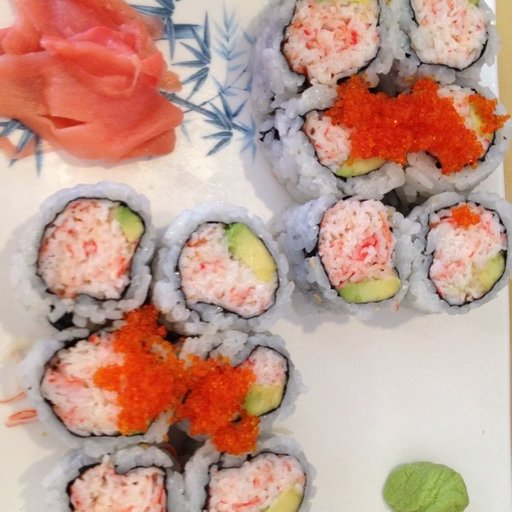

In [8]:
# visualizing an image
import random
from PIL import Image

# get all the image path
image_path_list = list(image_path.glob("*/*/*.jpg"))

# select a random image path
random_image_path = random.choice(image_path_list)
print(f"Path: {random_image_path}")

# get the image class
image_class = random_image_path.parent.stem
print(f"Image class: {image_class}")

# open the image
img = Image.open(random_image_path)
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

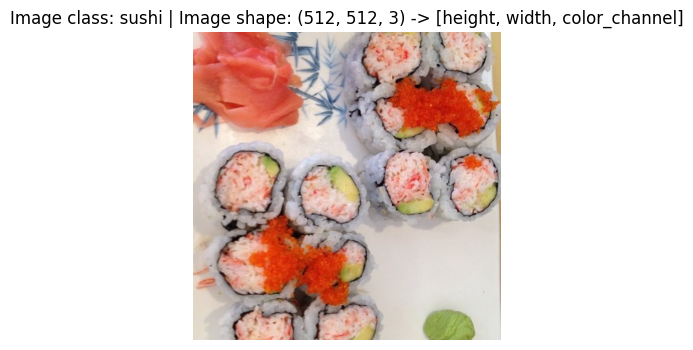

In [9]:
# try to visualize the image using matplotlib
import numpy as np
import matplotlib.pyplot as plt

# convert the image to numpy array
image_array = np.asarray(img)

# let's visualize the image
plt.figure(figsize=(6, 4))
plt.imshow(image_array)
plt.title(f"Image class: {image_class} | Image shape: {image_array.shape} -> [height, width, color_channel]")
plt.axis(False)
plt.show()

#### Transforming Data

In [10]:
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

In [21]:
# write a transformation for image
data_transform = transforms.Compose([
    # resize the image to 224X224
    transforms.Resize(size=(224, 224)),
    
    # flip the image randomly on the horizontal axis
    transforms.RandomHorizontalFlip(p=0.5),
    
    transforms.RandomRotation(10),
    #transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    
    # turn the image into torch.Tensor
    transforms.ToTensor()
])

In [22]:
data_transform(img)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [23]:
data_transform(img).shape

torch.Size([3, 224, 224])

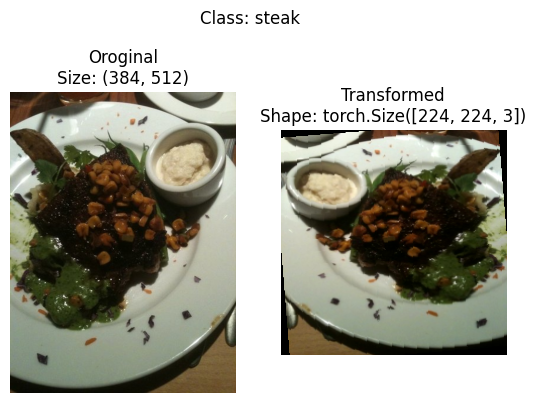

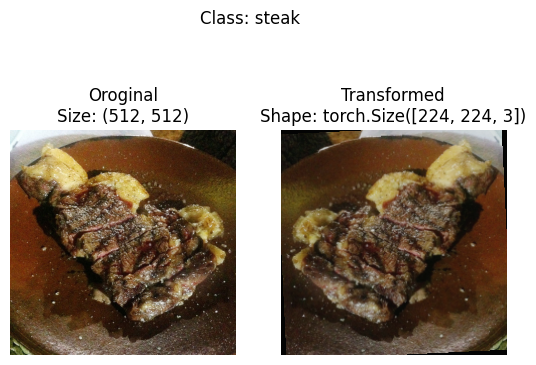

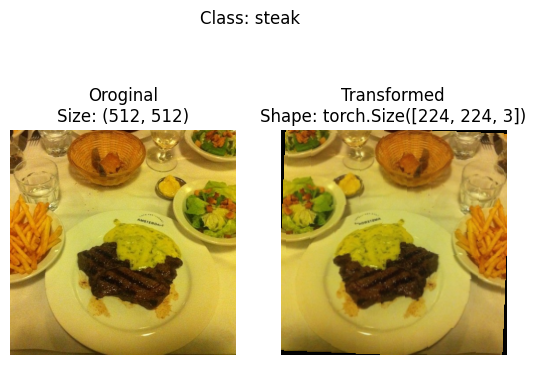

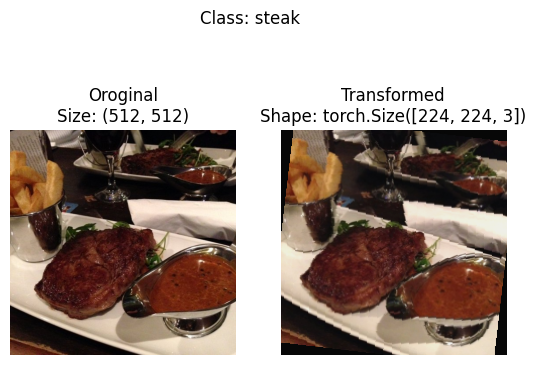

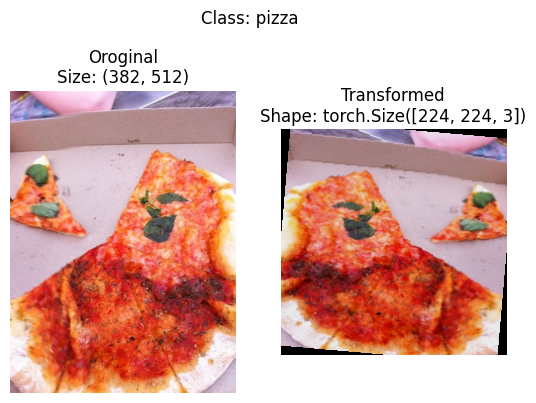

In [24]:

def plot_transformed_images(image_paths: list, transform: torchvision.transforms, n=3, seed=None):
    
    if seed:
        random.seed(seed)
    
    random_image_paths = random.sample(image_paths, k=n)
    
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            
            ax[0].imshow(f)
            ax[0].set_title(f"Oroginal\nSize: {f.size}")
            ax[0].axis(False)
            
            # transform and plot the image
            transformed_image = transform(f).permute(1, 2, 0)   # from [C, H, W] -> [H, W, C]
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis("off")
            
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=12)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=5,
                        seed=None)

#### Option 2: Loading image data with a custom dataset

In [26]:
import os
import pathlib
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import List, Tuple, Dict

In [32]:
# creating a helper function to get class names

target_dir = train_dir

class_names = sorted([entry.name for entry in list(os.scandir(target_dir))])
class_names

['pizza', 'steak', 'sushi']

In [35]:

def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """_summary_

    Args:
        directory (str): _description_

    Returns:
        Tuple[List[str], Dict[str, int]]: _description_
    """
    
    # get the class names
    classes = sorted(entry.name for entry in list(os.scandir(target_dir)) if entry.is_dir())
    
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check the file structure")
    
    # create a dictionary to index label
    class_to_indx = {class_name: i for i, class_name in enumerate(classes)}
    
    return classes, class_to_indx

In [38]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [39]:
train_dir

WindowsPath('data/pizza_steak_sushi/train')

In [57]:
# create a custon `Dataset` to replicate `ImageFolder`
# to create our own custom dataset we should subclass `torch.utils.data.Dataset`
# write a custom dataset class

class ImageFolderCustom(Dataset):
    
    def __init__(self, target_dir: str, transform: torchvision.transforms=None):
        super().__init__()
        
        self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_indx = self.find_classes(target_dir)
    
    def find_classes(self, directory: str) -> Tuple[List[str], Dict[str, int]]:
        """_summary_

        Args:
            directory (str): _description_

        Returns:
            Tuple[List[str], Dict[str, int]]: _description_
        """
    
        # get the class names
        classes = sorted(entry.name for entry in list(os.scandir(target_dir)) if entry.is_dir())

        if not classes:
            raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check the file structure")

        # create a dictionary to index label
        class_to_indx = {class_name: i for i, class_name in enumerate(classes)}

        return classes, class_to_indx
    
    def load_image(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)
    
    def __len__(self) -> int:
        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """_summary_

        Args:
            index (int): _description_

        Returns:
            Tuple[torch.Tensor, int]: One sample data i.e data and label (X, y)
        """
        img = self.load_image(index)
        class_name = self.paths[index].parent.name  # expect to have path in format: data_folder/class_name/image.jpg
        class_indx = self.class_to_indx[class_name]
        
        if self.transform:
            return self.transform(img), class_indx
        
        return img, class_indx  # return untransformed image and label

In [54]:
# data augmentation
# create a train transformation

train_transform = transforms.Compose([
    # resize the image to 224X224
    transforms.Resize(size=(224, 224)),
    
    # flip the image randomly on the horizontal axis
    transforms.RandomHorizontalFlip(p=0.5),
    
    transforms.RandomRotation(10),
    #transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    
    # turn the image into torch.Tensor
    transforms.ToTensor()
])


test_transform = transforms.Compose([
    # resize the image to 224X224
    transforms.Resize(size=(224, 224)),
    
    # turn the image into torch.Tensor
    transforms.ToTensor()
])

In [56]:
train_transform, test_transform

(Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
     RandomHorizontalFlip(p=0.5)
     RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
     ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=None, hue=None)
     ToTensor()
 ),
 Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
     ToTensor()
 ))

In [58]:
# create train and test data
train_data_custom = ImageFolderCustom(
    target_dir=train_dir,
    transform=train_transform
)

test_data_custom = ImageFolderCustom(
    target_dir=test_dir,
    transform=test_transform
)

In [62]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x25daed3f210>,
 <__main__.ImageFolderCustom at 0x25daed5de90>)

In [59]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [60]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [61]:
train_data_custom.class_to_indx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [66]:
img, label = train_data_custom[3]
img

tensor([[[0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         ...,
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118]],

        [[0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         ...,
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118]],

        [[0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.

In [67]:
img.shape

torch.Size([3, 224, 224])

In [70]:
label

0

In [79]:

def display_random_images(dataset: torch.utils.data.Dataset, classes: List[str],
                            n: int=10, display_shape: bool=True, seed: int=None):
    
    # 2. Adjust display if n too high
    if n >= 5:
        n = 5
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 5, setting to 5 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

For display purposes, n shouldn't be larger than 5, setting to 5 and removing shape display.


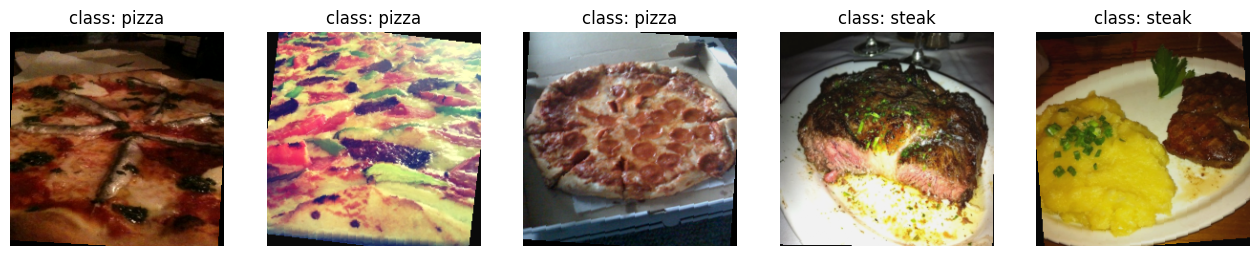

In [82]:
# train data
display_random_images(
    dataset=train_data_custom,
    classes=train_data_custom.classes,
    n=5,
    display_shape=True,
    seed=None
)

For display purposes, n shouldn't be larger than 5, setting to 5 and removing shape display.


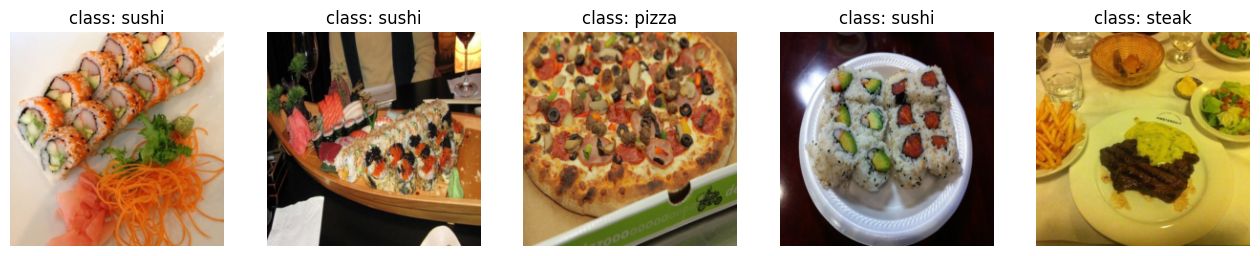

In [83]:
# test data
display_random_images(
    dataset=test_data_custom,
    classes=test_data_custom.classes,
    n=5,
    display_shape=True,
    seed=None
)

In [ ]:
# now, turn the  train and test dataset into dataloaders
from torch.utils.data import DataLoader

BATCH_SIZE = 4

train_dataloader = DataLoader(
    dataset=train_data_custom,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data_custom,
    batch_size=BATCH_SIZE
)

In [88]:
len(train_dataloader), len(test_dataloader)

(57, 19)

In [89]:
images, labels = next(iter(train_dataloader))
images.shape # [batch_size, C, H, W]

torch.Size([4, 3, 224, 224])

In [90]:
type(labels)

torch.Tensor

In [91]:
labels.shape

torch.Size([4])